# Extracting Ancient Placenames using Named Entity Recognition and `spaCy`

In this notebook, we are going to explore an important subfield of natural language processing, named entity recognition or NER. This notebook was inspired by William Mattingly's textbook on the subject, which you can find here: https://ner.pythonhumanities.com/intro.html. I encourage you to browse this book and play around with the code that he provides.

Objectives:
* Understand what NER is and why it matters
* Collect a training data for a machine learning NER approach
* Train a NER model using `spaCy`'s utilities
* Do some basic inference to see where our model suceeds and where it fails

## What is NER and why does it matter?

Named entity recognition describes any method which uses computational methods to extract from unstructured text names of people, places or things. It is a hard classification task, meaning that every word in a document is either a type of named entity or it is not. For example in the following sentences:
> My name is Peter Nadel. I work at Tufts University.

the token 'Peter Nadel' could be tagged as a PERSON tag, where as Tufts Univerisity could be tagged with a PLACE tag. Importantly, in NER, no token can receive more than one tag.

As a result, NER can be using in a wide variety of fields and applications.

In [1]:
# The example we'll be looking at today comes from these maps that I made
from IPython.display import IFrame
IFrame('https://tuftsgis.maps.arcgis.com/apps/webappviewer/index.html?id=576ff8f0e3954ad781916e94dfb34f7e', width=1400, height=800)

To make a map like the one we see above, I needed to extract place names from an ancient text. Thankfully, ToposText (https://topostext.org/) has marked all of the place names already. So why do we need NER?

ToposText has a lot of texts, but it doesn't have every ancient text. I work quite frequently with faculty members from Classic Studies, examining texts much more obscure than those in ToposText, which may not be digitized at all, let alone have place names marked. So, what we need is an ancient place name NER model, which we can pass any amount of texts and get back all of the places in that text.

*A quick note on `spaCy`'s native English NER*: `spaCy` has NER built into their English and other models. This NER is of good quality for modern texts, but is quite poor when applied to texts that aren't that similar to the training data (in the English model's case: modern news articles scraped from the web). For specialty tasks like the one we will do today, training your own model will always return better results.

# Scraping

Here, I will show how we got our training data and what form it has to be in for training NER models with `spaCy`.

In [ ]:
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
import requests

In [ ]:
res_html = requests.get("https://topostext.org/work/148").text # The Natural Histories, Plinius Senior

In [ ]:
topos_test = BeautifulSoup(res_html, features='html')

In [ ]:
p_tags = topos_test.find_all('p')[2:]
p_tags[3].a # first a tag in the third p tag

<a href="/people/1839" target="_blank">Livy</a>

`spaCy` expects the training data to be in `jsonl` format, meaning that there must be a list where each element is a list that contains the text and a dictionary of the entities that are in the text, with their label (in this case, their HTML class).

In [ ]:
import collections
import string
TRAIN_DATA = []

for i, p in enumerate(p_tags):
  document = []
  p_text = re.sub('(§\s\d\.\d+)|(§\s\d+)', '', p.text)
  document.append(p_text.replace('\xa0\xa0', ''))

  ent_dict = collections.defaultdict(list)
  for a in p.find_all('a'):
    span_list = []
    if a.text.istitle():
      if 'href' in a.attrs:
        span_list.append(a.text.translate(str.maketrans('', '', string.punctuation)))
        span_list.append(a['href'].split('/')[1])
      else:
        span_list.append(a.text.translate(str.maketrans('', '', string.punctuation)))
        span_list.append(a['class'][0])
    if len(span_list) > 0:
      ent_dict['entities'].append(span_list)
  document.append(dict(ent_dict))
  TRAIN_DATA.append(document)

In [ ]:
TRAIN_DATA[0]

Importantly though, you can't just use the text of the entities. It must be the indices of the names within the text. So we can do that below.

## TASK 1
We can't feed our model the raw text of a name. Instead, we need to give it the indices of the name in the original text.

Let's write some code to do that.

In [ ]:
test = TRAIN_DATA[0]
test

[".1But who could judge the value of these compositions with confidence when about to submit to the verdict of your talent, especially when that verdict has been invited? for formal dedication of the work to you puts one in a different position from mere publication. In the latter case I could have said: 'Why does your Highness read that? It was written for the common herd, the mob of farmers and of artisans, and after them for students who have nothing else to occupy their time: why do you put yourself on the jury? You were not on this panel when I took the contract for this undertaking: I knew you to be too great for me to think you likely to descend to this! Moreover even in the court of learning there is an official procedure for challenging the jury: it is employed even by Marcus Cicero, who where genius is in question stands outside all hazard... It may surprise us, but Cicero calls in the aid of council — nor yet for the very learned; Manius Persius I don't want to read this, I 

In [ ]:
type(test)

list

In [ ]:
test[0], type(test[0])

(".1But who could judge the value of these compositions with confidence when about to submit to the verdict of your talent, especially when that verdict has been invited? for formal dedication of the work to you puts one in a different position from mere publication. In the latter case I could have said: 'Why does your Highness read that? It was written for the common herd, the mob of farmers and of artisans, and after them for students who have nothing else to occupy their time: why do you put yourself on the jury? You were not on this panel when I took the contract for this undertaking: I knew you to be too great for me to think you likely to descend to this! Moreover even in the court of learning there is an official procedure for challenging the jury: it is employed even by Marcus Cicero, who where genius is in question stands outside all hazard... It may surprise us, but Cicero calls in the aid of council — nor yet for the very learned; Manius Persius I don't want to read this, I 

In [ ]:
test[1], type(test[1])

({'entities': [['Cicero', 'people'],
   ['Cicero', 'people'],
   ['Manius', 'people'],
   ['Persius', 'people'],
   ['Junius Congus', 'people']]},
 dict)

In [ ]:
test[1]['entities'], type(test[1]['entities'])

([['Cicero', 'people'],
  ['Cicero', 'people'],
  ['Manius', 'people'],
  ['Persius', 'people'],
  ['Junius Congus', 'people']],
 list)

In [ ]:
test[1]['entities'][0], type(test[1]['entities'][0])

(['Cicero', 'people'], list)

In [ ]:
test[1]['entities'][0][0], type(test[1]['entities'][0][0])

('Cicero', str)

### Answer
`TRAIN_DATA` -> `List[String, Dict[List[String, String]]]`

In [ ]:
test[0].find('Cicero')

794

In [ ]:
test[1]['entities']

[['Cicero', 'people'],
 ['Cicero', 'people'],
 ['Manius', 'people'],
 ['Persius', 'people'],
 ['Junius Congus', 'people']]

In [ ]:
# using find method
test[0].find(test[1]['entities'][0][0])

794

In [ ]:
# add length of the original string
start = test[0].find(test[1]['entities'][0][0])
end = start + len(test[1]['entities'][0][0])
start, end

(794, 800)

In [ ]:
# check
test[0][794:800] # looks good!

'Cicero'

In [ ]:
# turn this into a function we can use for each string
def names2indices(train_data_instance):
  for i, name in enumerate(train_data_instance[1]['entities']):
    # get indices
    start = train_data_instance[0].find(name[0])
    if start != -1:
      end = start + len(name[0])
    else:
      pass

    # update dict
    train_data_instance[1]['entities'][i].pop(0) # remove string name
    train_data_instance[1]['entities'][i].insert(0, end) # add end
    train_data_instance[1]['entities'][i].insert(0, start) # add start

In [ ]:
# do it to all of them in our training data
for instance in TRAIN_DATA:
  if 'entities' in instance[1].keys():
    names2indices(instance)

In [ ]:
TRAIN_DATA[0]

[".1But who could judge the value of these compositions with confidence when about to submit to the verdict of your talent, especially when that verdict has been invited? for formal dedication of the work to you puts one in a different position from mere publication. In the latter case I could have said: 'Why does your Highness read that? It was written for the common herd, the mob of farmers and of artisans, and after them for students who have nothing else to occupy their time: why do you put yourself on the jury? You were not on this panel when I took the contract for this undertaking: I knew you to be too great for me to think you likely to descend to this! Moreover even in the court of learning there is an official procedure for challenging the jury: it is employed even by Marcus Cicero, who where genius is in question stands outside all hazard... It may surprise us, but Cicero calls in the aid of council — nor yet for the very learned; Manius Persius I don't want to read this, I 

## Completing our training data

Now that we can do this to one ToposText URL we can do it to all the others.

In [ ]:
# can make this into a single function
def create_TRAIN_DATA(url):
  """
  Takes in a ToposText URL and creates spaCy training data.
  """

  # scraping
  res = requests.get(url)
  if res:
    res_html = res.text

    soup = BeautifulSoup(res_html, features='html')
    TRAIN_DATA = []

    p_tags = soup.find_all('p')[1:]
    for i, p in enumerate(p_tags):
      document = []
      p_text = re.sub('(§\s\d\.\d+)|(§\s\d+)', '', p.text)
      document.append(p_text.replace('\xa0\xa0', ''))

      ent_dict = collections.defaultdict(list)
      for a in p.find_all('a'):
        span_list = []
        if a.text.istitle():
          if 'href' in a.attrs:
            span_list.append(a.text)
            span_list.append(a['href'].split('/')[1])
          else:
            try:
              span_list.append(a.text)
              span_list.append(a['class'][0])
            except:
              continue
        if len(span_list) > 0:
          ent_dict['entities'].append(span_list)
      document.append(dict(ent_dict))
      TRAIN_DATA.append(document)

    # reformating
    for instance in TRAIN_DATA:
      if 'entities' in instance[1].keys():
        names2indices(instance)

    return TRAIN_DATA

In [ ]:
create_TRAIN_DATA('https://topostext.org/work/148')

[['.1PREFACE IN THE FORM OF A LETTER: PLINIUS SECUNDUS TO HIS DEAR VESPASIAN, GREETING MOST Gracious Highness (let this title, a supremely true one, be yours, while that of \'Most Eminent\' grows to old age with your sire) — I have resolved to recount to you, in a somewhat presumptuous letter, The offspring of my latest travail, my volumes of Natural History (a novel task for the native Muses of your Roman citizens) — For \'twas e\'er your way, To deem my trifles something worth — to give a passing touch of polish to my "opposite number" — you recognize even this service slang — Catullus (for he, as you know, by interchanging the first syllables made himself a trifle harsher than he wished to be considered by his \'darling Veraniuses and Fabulluses\') and at the same time that my present sauciness may effect what in the case of another impudent letter of mine lately you complained of as not coming off — that it may result in something getting done, and everyone may know on what equal t

In [ ]:
TRAIN_DATA = []
# Max of 901
for i in tqdm(range(2, 901)):
  train = create_TRAIN_DATA(f'https://topostext.org/work/{i}')
  for item in train:
    TRAIN_DATA.append(item)

100%|██████████| 899/899 [16:31<00:00,  1.10s/it]


In [ ]:
len(TRAIN_DATA)

154762

In [ ]:
TRAIN_DATA[:3]

[["BOOK 1  The wrath sing, goddess, of Peleus' son, Achilles, that destructive wrath which brought countless woes upon the Achaeans, and sent forth to Hades many valiant souls of heroes, and made them themselves spoil for dogs and every bird; thus the plan of Zeus came to fulfillment, ",
  {'entities': [[36, 42, 'people'],
    [49, 57, 'people'],
    [120, 128, 'ethnic'],
    [148, 153, 'people'],
    [257, 261, 'people']]}],
 ["from the time when first they parted in strife Atreus' son, king of men, and brilliant Achilles. Who then of the gods was it that brought these two together to contend? The son of Leto and Zeus; for he in anger against the king roused throughout the host an evil pestilence, and the people began to perish, ",
  {'entities': [[47, 53, 'people'],
    [87, 95, 'people'],
    [180, 184, 'people'],
    [189, 193, 'people']]}],
 ['because upon the priest Chryses the son of Atreus had wrought dishonour. For he had come to the swift ships of the Achaeans to free his dau

In [ ]:
# pickling let's us save this work so we don't have to do it again
import pickle

file_name = "topostext_training_data.pkl"

# pickle and save the data
with open(file_name, 'wb') as file:
    pickle.dump(TRAIN_DATA, file)

print(f"Training data saved to {file_name}")

Training data saved to topostext_training_data.pkl


# Training
Now that we have our data in the correct form, we can start training.

First, we have to convert the `TRAIN_DATA` object into a special `spaCy` type called a `DocBin` (code taken from Mattingly).

In [ ]:
!wget https://tufts.box.com/shared/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl -O topostext_training_data.pkl

--2023-11-13 14:45:34--  https://tufts.box.com/shared/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl
Resolving tufts.box.com (tufts.box.com)... 74.112.186.144
Connecting to tufts.box.com (tufts.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl [following]
--2023-11-13 14:45:34--  https://tufts.box.com/public/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl
Reusing existing connection to tufts.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://tufts.app.box.com/public/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl [following]
--2023-11-13 14:45:35--  https://tufts.app.box.com/public/static/2p4ez2vas90v2zn8mf3lgdv6lltzl75d.pkl
Resolving tufts.app.box.com (tufts.app.box.com)... 74.112.186.144
Connecting to tufts.app.box.com (tufts.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https:/

In [ ]:
import pickle
with open('/content/topostext_training_data.pkl', 'rb') as file:
    loaded_training_data = pickle.load(file)

print("Loaded training data length:", len(loaded_training_data))

Loaded training data length: 154762


In [ ]:
loaded_training_data[0]

["BOOK 1  The wrath sing, goddess, of Peleus' son, Achilles, that destructive wrath which brought countless woes upon the Achaeans, and sent forth to Hades many valiant souls of heroes, and made them themselves spoil for dogs and every bird; thus the plan of Zeus came to fulfillment, ",
 {'entities': [[36, 42, 'people'],
   [49, 57, 'people'],
   [120, 128, 'ethnic'],
   [148, 153, 'people'],
   [257, 261, 'people']]}]

The above section in the original Greek.

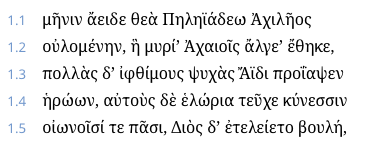

In [ ]:
!mkdir data

In [ ]:
import spacy
from spacy.tokens import DocBin
from pathlib import Path
import warnings

def convert(lang: str, TRAIN_DATA, output_path: Path):
    nlp = spacy.blank(lang)
    nlp.max_length = 2000000
    db = DocBin()
    for text, annot in TRAIN_DATA:
        doc = nlp.make_doc(text)
        ents = []
        if 'entities' in annot.keys():
          for start, end, label in annot["entities"]:
              span = doc.char_span(start, end, label=label)
              if span is None:
                  msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
                  warnings.warn(msg)
              else:
                  ents.append(span)
        try:
          doc.ents = ents
        except:
          continue
        db.add(doc)
    db.to_disk(output_path)

In [ ]:
from sklearn.model_selection import train_test_split

# two splits: first split (train and validation for testing our model after it trains)
train_valid, valid_post_training = train_test_split(loaded_training_data, test_size=0.2, random_state=1)

train, valid = train_test_split(train_valid, test_size=0.2, random_state=1)

In [ ]:
len(train), len(valid), len(valid_post_training)

(99047, 24762, 30953)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

convert("en", train, "/content/data/train.spacy")
convert("en", valid, "/content/data/valid.spacy")

In [ ]:
import os
os.listdir("/content/data")

['train.spacy', 'valid.spacy']

### TASK 2

We still need one final piece before we can start training. This is the config file that weill tell the training program how to initialize our set up. We can download a blank version here: https://spacy.io/usage/training.

Finally we just need to add the file locations of our training and validation data. In Colab, double-clicking on the base_config.cfg file will open up an editor on the side. In the train field, put `data/train.spacy` and in the dev field, put `data/valid.spacy`.

In [ ]:
!python -m spacy init fill-config /content/base_config.cfg /content/config.cfg

2023-11-13 15:00:11.253946: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 15:00:11.254067: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 15:00:11.254182: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 15:00:12.896805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Auto-filled config with all values
✔ Saved config
/content/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [ ]:
# really useful feature in spacy
!python -m spacy debug data /content/config.cfg

2023-10-25 14:17:17.278698: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 14:17:17.278778: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 14:17:17.278810: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 14:17:18.437604: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

============================ Data file validation ============================
✔ Pipeline can be initialized with data
✔ Corpus is loadable

=============================== Training stats ===============================
Language: en
Trai

In [ ]:
!python -m spacy train config.cfg --output models

2023-10-25 14:23:10.368690: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-25 14:23:10.368765: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-25 14:23:10.368799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-25 14:23:11.524989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Created output directory: models
ℹ Saving to output directory: models
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline ===

In [ ]:
# zip up model for easier download
!zip -r topostext_ner_model_full.zip models

  adding: models/ (stored 0%)
  adding: models/model-best/ (stored 0%)
  adding: models/model-best/meta.json (deflated 61%)
  adding: models/model-best/vocab/ (stored 0%)
  adding: models/model-best/vocab/vectors (deflated 45%)
  adding: models/model-best/vocab/vectors.cfg (stored 0%)
  adding: models/model-best/vocab/key2row (stored 0%)
  adding: models/model-best/vocab/strings.json (deflated 81%)
  adding: models/model-best/vocab/lookups.bin (stored 0%)
  adding: models/model-best/config.cfg (deflated 60%)
  adding: models/model-best/tokenizer (deflated 81%)
  adding: models/model-best/ner/ (stored 0%)
  adding: models/model-best/ner/model (deflated 9%)
  adding: models/model-best/ner/cfg (deflated 33%)
  adding: models/model-best/ner/moves (deflated 64%)
  adding: models/model-best/tok2vec/ (stored 0%)
  adding: models/model-best/tok2vec/model (deflated 7%)
  adding: models/model-best/tok2vec/cfg (stored 0%)
  adding: models/model-last/ (stored 0%)
  adding: models/model-last/meta.j

In [ ]:
from google.colab import files
files.download('topostext_ner_model_full.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Inference

Now that we have a model, we can see how well we did. For this inference step, I want to use example texts that I know were not in the training data.

In [ ]:
!git clone https://github.com/pnadelofficial/topos_text_NER.git

Cloning into 'topos_text_NER'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 48 (delta 9), reused 28 (delta 1), pack-reused 0
Receiving objects: 100% (48/48), 45.28 MiB | 28.71 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!unzip topos_text_NER/topostext_ner_model_full.zip

Archive:  topos_text_NER/topostext_ner_model_full.zip
   creating: models/
   creating: models/model-best/
  inflating: models/model-best/meta.json  
   creating: models/model-best/vocab/
  inflating: models/model-best/vocab/vectors  
 extracting: models/model-best/vocab/vectors.cfg  
 extracting: models/model-best/vocab/key2row  
  inflating: models/model-best/vocab/strings.json  
 extracting: models/model-best/vocab/lookups.bin  
  inflating: models/model-best/config.cfg  
  inflating: models/model-best/tokenizer  
   creating: models/model-best/ner/
  inflating: models/model-best/ner/model  
  inflating: models/model-best/ner/cfg  
  inflating: models/model-best/ner/moves  
   creating: models/model-best/tok2vec/
  inflating: models/model-best/tok2vec/model  
 extracting: models/model-best/tok2vec/cfg  
   creating: models/model-last/
  inflating: models/model-last/meta.json  
   creating: models/model-last/vocab/
  inflating: models/model-last/vocab/vectors  
 extracting: models/mo

In [ ]:
inf_text ='''
An upper vest, once Helen's rich attire,
From Argos by the fam'd adultress brought,
With golden flow'rs and winding foliage wrought,
Her mother Leda's present, when she came
To ruin Troy and set the world on flame;
The scepter Priam's eldest daughter bore,
Her orient necklace, and the crown she wore
Of double texture, glorious to behold,
One order set with gems, and one with gold.
'''

# Vergil Aenid 1.643
# perseus.tufts.edu/hopper/text?doc=Perseus%3Atext%3A1999.02.0052%3Abook%3D1%3Acard%3D643

In [ ]:
import spacy
trained_nlp = spacy.load("models/model-best")

In [ ]:
doc = trained_nlp(inf_text)

In [ ]:
type(doc)

spacy.tokens.doc.Doc

In [ ]:
places = []
for ent in doc.ents:
  if ent.label_ == 'people':
    places.append(ent)

In [ ]:
places

[Menedaius, Eurylochus, Demosthenes, Menedaius, Demosthenes]

In [ ]:
!python -m spacy download en_core_web_sm

2023-11-13 15:13:22.622202: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-13 15:13:22.622300: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-13 15:13:22.622351: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-13 15:13:24.430834: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
test_doc = nlp("My name is Peter")

In [ ]:
for word in test_doc:
  print(word.text, word.pos_, word.lemma_)

My PRON my
name NOUN name
is AUX be
Peter PROPN Peter


In [ ]:
# code to get all entities
[(e, e.label_) for e in doc.ents]

[(Helen, 'people'),
 (Argos, 'place'),
 (Leda, 'people'),
 (Troy, 'place'),
 (Priam, 'people')]

### Evaluation

In this section, we'll use the `valid_post_training` list of examples to calculate an F1 score for our model. This score is a good summary of how well our model does on this NER task, as it not only counts what entities the model correctly identified, but also considers if their labels are correct as well.

F1 score is the harmonic mean of *precision*, the ratio of correctly identified entities (true positives, TP) and all identified entities (the sum of true positives and false positives, FP), and *recall*, the ratio of correctly identified entities (TP) and all true entities (true positives and false negatives, FN).

$Precision = \frac{TP}{TP+FP}$

$Recall = \frac{TP}{TP+FN}$

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$

In [ ]:
len(valid_post_training)

30953

In [ ]:
valid_post_training[0]

['The next day Menedaius, who on the death of Eurylochus and Macarius had succeeded to the sole command, being at a loss after so signal a defeat how to stay and sustain a siege, cut off as he was by land and by the Athenian fleet by sea, and equally so how to retreat in safety, opened a parley with Demosthenes and the Acarnanian generals for a truce and permission to retreat, and at the same time for the recovery of the dead. 2 The dead they gave back to him, and setting up a trophy took up their own also to the number of about three hundred. The retreat demanded they refused publicly to the army; but permission to depart without delay was secretly granted to the Mantineans and to Menedaius and the other commanders and principal men of the Peloponnesians by Demosthenes and his Acarnanian colleagues; who desired to strip the Ambraciots and the mercenary host of foreigners of their supporters; and, above all, to discredit the Lacedaemonians and Peloponnesians with the Hellenes in those 

In [ ]:
import spacy
trained_nlp = spacy.load("models/model-best")

In [ ]:
doc = trained_nlp(valid_post_training[0][0])
predicted_ents = [(d.text, d.label_) for d in doc.ents]
predicted_ents

[('Menedaius', 'people'),
 ('Eurylochus', 'people'),
 ('Athenian', 'demonym'),
 ('Demosthenes', 'people'),
 ('Acarnanian', 'person'),
 ('Mantineans', 'ethnic'),
 ('Menedaius', 'people'),
 ('Peloponnesians', 'ethnic'),
 ('Demosthenes', 'people'),
 ('Acarnanian', 'demonym'),
 ('Ambraciots', 'ethnic'),
 ('Lacedaemonians', 'ethnic'),
 ('Peloponnesians', 'ethnic')]

In [ ]:
true_ents_raw = valid_post_training[0][1]['entities']
true_ents = []
for te in true_ents_raw:
  text = valid_post_training[0][0][te[0]:te[1]]
  true_ents.append((text, te[-1]))

true_ents

[('Eurylochus', 'people'),
 ('Athenian', 'demonym'),
 ('Demosthenes', 'people'),
 ('Acarnanian', 'demonym'),
 ('Mantineans', 'ethnic'),
 ('Peloponnesians', 'ethnic'),
 ('Demosthenes', 'people'),
 ('Acarnanian', 'demonym'),
 ('Ambraciots', 'ethnic'),
 ('Lacedaemonians', 'ethnic'),
 ('Peloponnesians', 'ethnic')]

In [ ]:
predicted_set = set(predicted_ents)
true_set = set(true_ents)

In [ ]:
true_positives = len(predicted_set.intersection(true_set))
false_positives = len(predicted_set - true_set)
false_negatives = len(true_set - predicted_set)

In [ ]:
precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

In [ ]:
precision, recall, f1_score

(0.8, 1.0, 0.888888888888889)

In [ ]:
def eval_one(i):
  doc = trained_nlp(valid_post_training[i][0])
  predicted_ents = [(d.text, d.label_) for d in doc.ents]

  true_ents_raw = valid_post_training[i][1]['entities']
  true_ents = []
  for te in true_ents_raw:
    text = valid_post_training[i][0][te[0]:te[1]]
    true_ents.append((text, te[-1]))

  predicted_set = set(predicted_ents)
  true_set = set(true_ents)

  true_positives = predicted_set.intersection(true_set)
  false_positives = predicted_set - true_set
  false_negatives = true_set - predicted_set

  return len(true_positives), len(false_positives), len(false_negatives)

In [ ]:
from tqdm import tqdm # for the progress bar

all_true_positives = 0
all_false_positives = 0
all_false_negatives = 0

for i in tqdm(range(len(valid_post_training))):
  if 'entities' in valid_post_training[i][1]:
    tp, fp, fn = eval_one(i)
    all_true_positives += tp
    all_false_positives += fp
    all_false_negatives += fn

precision = all_true_positives / (all_true_positives + all_false_positives)
recall = all_true_positives / (all_true_positives + all_false_negatives)
f1_score = 2 * (precision * recall) / (precision + recall)

100%|██████████| 30953/30953 [04:06<00:00, 125.67it/s]


In [ ]:
round(f1_score, 3) # not too shabby!

0.895

Yay! We did it!